<a href="https://colab.research.google.com/github/hsabaghpour/Pandas-to-cuDF-Performance-Comparison/blob/main/GPU_Accelerated_Data_Analysis_with_RAPIDS_cuDF_A_Performance_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**RAPIDS cuDF's pandas Accelerator**

cuDF is a Python GPU DataFrame library using Apache Arrow's columnar format. It handles data loading, joining, aggregating, filtering, and manipulation with a pandas-like API.


With the new pandas accelerator mode (cudf.pandas), you can now speed up your pandas workflows using GPU acceleration without changing your code.

This notebook offers a quick introduction to cudf.pandas.

In [1]:
!nvidia-smi  # this should display information about available GPUs

Wed Jul 17 20:29:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import cudf

In [3]:
!pip install plotly-express #install plotly-express for visualizing data.

**Download the Data**

We'll be using the Parking Violations Issued - Fiscal Year 2022 dataset from NYC Open Data.








In [5]:
!wget https://data.rapids.ai/datasets/nyc_parking/nyc_parking_violations_2022.parquet

--2024-07-17 20:33:10--  https://data.rapids.ai/datasets/nyc_parking/nyc_parking_violations_2022.parquet
Resolving data.rapids.ai (data.rapids.ai)... 99.86.38.104, 99.86.38.57, 99.86.38.102, ...
Connecting to data.rapids.ai (data.rapids.ai)|99.86.38.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 474211285 (452M) [binary/octet-stream]
Saving to: ‘nyc_parking_violations_2022.parquet.1’

nyc_parking_violati 100%[===================>] 452.24M   265MB/s    in 1.7s    

2024-07-17 20:33:12 (265 MB/s) - ‘nyc_parking_violations_2022.parquet.1’ saved [474211285/474211285]



In [7]:
#Analysis using Standard Pandas

import pandas as pd


df = pd.read_parquet(
    "nyc_parking_violations_2022.parquet",
    columns=["Registration State", "Violation Description", "Vehicle Body Type", "Issue Date", "Summons Number"]
)

# just a sample check of 10 rows:
df.sample(10)

,Registration State,Violation Description,Vehicle Body Type,Issue Date,Summons Number
12606663,NY,70A-Reg. Sticker Expired (NYS),4DSD,04/17/2022,8904001079
7474039,IN,46B-Double Parking (Com-100Ft),TRAC,12/21/2021,8837726983
2236730,NY,78-Nighttime PKG on Res Street,DUMP,08/18/2021,8830396930
9704657,NY,68-Not Pkg. Comp. w Psted Sign,SUBN,01/28/2022,8855428871
10668050,NY,PHTO SCHOOL ZN SPEED VIOLATION,SUBN,03/24/2022,4772643540
4555050,NY,PHTO SCHOOL ZN SPEED VIOLATION,PICK,09/29/2021,4751021394
1724791,NY,20A-No Parking (Non-COM),SUBN,07/31/2021,8973495987
1297224,NY,38-Failure to Dsplay Meter Rec,4DSD,06/28/2021,8960980560
2561331,NY,71A-Insp Sticker Expired (NYS),4DSD,08/04/2021,8943137308
12316426,NY,PHTO SCHOOL ZN SPEED VIOLATION,SUBN,04/01/2022,4774192168


**NOW Let's do some data expolaration using Pandas:**

#**Analyzing Parking Violations Data**

**Most common parking violation by state:**


Use value_counts and GroupBy.head in Pandas to find the most frequent offense for each state.

**Frequent vehicle body types in violations:**

Identify the vehicle body types most often involved in parking violations.
Violations by day of the week:

**Examine the distribution of violations across different days.**

In [8]:
(df[["Registration State", "Violation Description"]]  # get only these two columns
 .value_counts()  # get the count of offences per state and per type of offence
 .groupby("Registration State")  # group by state
 .head(1)  # get the first row in each group (the type of offence with the largest count)
 .sort_index()  # sort by state name
 .reset_index()
)

,Registration State,Violation Description,count
0,99,<NA>,17550
1,AB,14-No Standing,22
2,AK,PHTO SCHOOL ZN SPEED VIOLATION,125
3,AL,PHTO SCHOOL ZN SPEED VIOLATION,3668
4,AR,PHTO SCHOOL ZN SPEED VIOLATION,537
...,...,...,...
62,VT,PHTO SCHOOL ZN SPEED VIOLATION,3024
63,WA,21-No Parking (street clean),3732
64,WI,14-No Standing,1639
65,WV,PHTO SCHOOL ZN SPEED VIOLATION,1185


In [9]:
#Which vehicle body types are most frequently involved in parking violations?

(df
 .groupby(["Vehicle Body Type"])
 .agg({"Summons Number": "count"})
 .rename(columns={"Summons Number": "Count"})
 .sort_values(["Count"], ascending=False)
)

,Count
Vehicle Body Type,
SUBN,6449007
4DSD,4402991
VAN,1317899
DELV,436430
PICK,429798
...,...
CARY,1
ISUZ,1
IXMR,1


In [10]:
weekday_names = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday",
}

df["Issue Date"] = df["Issue Date"].astype("datetime64[ms]")
df["issue_weekday"] = df["Issue Date"].dt.weekday.map(weekday_names)

df.groupby(["issue_weekday"])["Summons Number"].count().sort_values()

issue_weekday
Sunday        462992
Saturday     1108385
Monday       2488563
Wednesday    2760088
Tuesday      2809949
Friday       2891679
Thursday     2913951
Name: Summons Number, dtype: int64

In [11]:
#Let's measure the time!
#Loading and processing this data took a while. Now, let's see how long these operations take in

%%time

df = pd.read_parquet(
    "nyc_parking_violations_2022.parquet",
    columns=["Registration State", "Violation Description", "Vehicle Body Type", "Issue Date", "Summons Number"]
)

(df[["Registration State", "Violation Description"]]
 .value_counts()
 .groupby("Registration State")
 .head(1)
 .sort_index()
 .reset_index()
)

CPU times: user 5.93 s, sys: 2.1 s, total: 8.03 s
Wall time: 6.77 s


,Registration State,Violation Description,count
0,99,<NA>,17550
1,AB,14-No Standing,22
2,AK,PHTO SCHOOL ZN SPEED VIOLATION,125
3,AL,PHTO SCHOOL ZN SPEED VIOLATION,3668
4,AR,PHTO SCHOOL ZN SPEED VIOLATION,537
...,...,...,...
62,VT,PHTO SCHOOL ZN SPEED VIOLATION,3024
63,WA,21-No Parking (street clean),3732
64,WI,14-No Standing,1639
65,WV,PHTO SCHOOL ZN SPEED VIOLATION,1185


In [12]:
%%time

(df
 .groupby(["Vehicle Body Type"])
 .agg({"Summons Number": "count"})
 .rename(columns={"Summons Number": "Count"})
 .sort_values(["Count"], ascending=False)
)

CPU times: user 846 ms, sys: 223 ms, total: 1.07 s
Wall time: 1.25 s


,Count
Vehicle Body Type,
SUBN,6449007
4DSD,4402991
VAN,1317899
DELV,436430
PICK,429798
...,...
CARY,1
ISUZ,1
IXMR,1


In [13]:
%%time

weekday_names = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday",
}

df["Issue Date"] = df["Issue Date"].astype("datetime64[ms]")
df["issue_weekday"] = df["Issue Date"].dt.weekday.map(weekday_names)

df.groupby(["issue_weekday"])["Summons Number"].count().sort_values()

CPU times: user 3.52 s, sys: 550 ms, total: 4.07 s
Wall time: 4.06 s


issue_weekday
Sunday        462992
Saturday     1108385
Monday       2488563
Wednesday    2760088
Tuesday      2809949
Friday       2891679
Thursday     2913951
Name: Summons Number, dtype: int64

##**Using cudf.pandas**

Exciting times ahead! Let’s re-run the Pandas code using the **cudf.** extension.


Normally, you'd start by loading cudf.pandas first in your notebook, before any other imports. For now, we’re simulating that by restarting the kernel.

In [14]:
get_ipython().kernel.do_shutdown(restart=True)

{'status': 'ok', 'restart': True}

In [1]:
%load_ext cudf.pandas

In [2]:
%%time

import pandas as pd

df = pd.read_parquet(
    "nyc_parking_violations_2022.parquet",
    columns=["Registration State", "Violation Description", "Vehicle Body Type", "Issue Date", "Summons Number"]
)

(df[["Registration State", "Violation Description"]]
 .value_counts()
 .groupby("Registration State")
 .head(1)
 .sort_index()
 .reset_index()
)

CPU times: user 743 ms, sys: 321 ms, total: 1.06 s
Wall time: 1.47 s


,Registration State,Violation Description,count
0,99,<NA>,17550
1,AB,14-No Standing,22
2,AK,PHTO SCHOOL ZN SPEED VIOLATION,125
3,AL,PHTO SCHOOL ZN SPEED VIOLATION,3668
4,AR,PHTO SCHOOL ZN SPEED VIOLATION,537
...,...,...,...
62,VT,PHTO SCHOOL ZN SPEED VIOLATION,3024
63,WA,21-No Parking (street clean),3732
64,WI,14-No Standing,1639
65,WV,PHTO SCHOOL ZN SPEED VIOLATION,1185


In [3]:
%%time

(df
 .groupby(["Vehicle Body Type"])
 .agg({"Summons Number": "count"})
 .rename(columns={"Summons Number": "Count"})
 .sort_values(["Count"], ascending=False)
)

CPU times: user 25.1 ms, sys: 5.01 ms, total: 30.1 ms
Wall time: 51.9 ms


,Count
Vehicle Body Type,
SUBN,6449007
4DSD,4402991
VAN,1317899
DELV,436430
PICK,429798
...,...
YANT,1
YBSD,1
YEL,1


In [4]:
%%time

weekday_names = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday",
}

df["Issue Date"] = df["Issue Date"].astype("datetime64[ms]")
df["issue_weekday"] = df["Issue Date"].dt.weekday.map(weekday_names)

df.groupby(["issue_weekday"])["Summons Number"].count().sort_values()

CPU times: user 234 ms, sys: 76.7 ms, total: 311 ms
Wall time: 405 ms


issue_weekday
Sunday        462992
Saturday     1108385
Monday       2488563
Wednesday    2760088
Tuesday      2809949
Friday       2891679
Thursday     2913951
Name: Summons Number, dtype: int64

##**Understanding Performance**

**Profiling Tools:** cudf.pandas offers utilities to analyze which parts of your code run on the GPU and which on the CPU.

**Access:** Profiling tools are available in the cudf.pandas namespace.

**Colab Note:** Initial profiling in Colab may take longer due to debugger interaction. Just run the cell again if needed.


In [5]:

#Profiling Options: Generate profiles for individual functions and lines of code.

In [6]:


%%cudf.pandas.profile

small_df = pd.DataFrame({'a': [0, 1, 2], 'b': ["x", "y", "z"]})
small_df = pd.concat([small_df, small_df])

axis = 0
for i in range(0, 2):
    small_df.min(axis=axis, numeric_only=True)
    axis = 1

counts = small_df.groupby("a").b.count()


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.10/dist-packages/cudf/pandas/profiler.py", line 97, in __enter__
    sys.settrace(self._tracefunc)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.10/dist-packages/cudf/pandas/profiler.py", line 116, in __exit__
    sys.settrace(self._oldtrace)



                                                                                                         
                                       Total time elapsed: 10.791 seconds                                
                                     6 GPU function calls in 10.306 seconds                              
                                      0 CPU function calls in 0.000 seconds                              
                                                                                                         
                                                      Stats                                              
                                                                                                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function            ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DataFrame           │ 1          │ 0.007       │ 0.007       │ 0          │ 0.000       │ 0.000       │
│ concat              │ 1          │ 0.013       │ 0.013       │ 0          │ 0.000       │ 0.000       │
│ DataFrame.min       │ 2          │ 10.274      │ 5.137       │ 0          │ 0.000       │ 0.000       │
│ DataFrame.groupby   │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ SeriesGroupBy.count │ 1          │ 0.011       │ 0.011       │ 0          │ 0.000       │ 0.000       │
└─────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [7]:
%%cudf.pandas.line_profile

small_df = pd.DataFrame({'a': [0, 1, 2], 'b': ["x", "y", "z"]})
small_df = pd.concat([small_df, small_df])

axis = 0
for i in range(0, 2):
    small_df.min(axis=axis, numeric_only=True)
    axis = 1

counts = small_df.groupby("a").b.count()

                                                                                                              
                                          Total time elapsed: 2.103 seconds                                   
                                                                                                              
                                                        Stats                                                 
                                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Line no. ┃ Line                                                                ┃ GPU TIME(s) ┃ CPU TIME(s) ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ 2        │     small_df = pd.DataFrame({'a': [0, 1, 2], 'b': ["x", "y", "z"]}) │ 0.003146351 │             │
│          │                                                                     │             │             │
│ 3        │     small_df = pd.concat([small_df, small_df])                      │ 0.007788984 │             │
│          │                                                                     │             │             │
│ 5        │     axis = 0                                                        │             │             │
│          │                                                                     │             │             │
│ 6        │     for i in range(0, 2):                                           │             │             │
│          │                                                                     │             │             │
│ 7        │         small_df.min(axis=axis, numeric_only=True)                  │ 0.018554791 │             │
│          │                                                                     │             │             │
│ 8        │         axis = 1                                                    │             │             │
│          │                                                                     │             │             │
│ 10       │     counts = small_df.groupby("a").b.count()                        │ 0.009575754 │             │
│          │                                                                     │             │             │
└──────────┴─────────────────────────────────────────────────────────────────────┴─────────────┴─────────────┘

##**What’s Happening Behind the Scenes?**

When you activate **cudf.pandas**, Pandas objects like Series and DataFrame become proxy objects that route operations to cuDF where applicable. You can confirm that cudf.pandas is working by checking the pd variable.

In [8]:
pd

<module 'pandas' (ModuleAccelerator(fast=cudf, slow=pandas))>

In [10]:
#Consequenty all pandas functions, methodes and any new objects will be flagged as proxies. like below as an exapmle:

type(pd.read_csv)

cudf.pandas.fast_slow_proxy._FunctionProxy

In [11]:
#which leads to fast operaton supporded on cuDF.
%%time
df.count(axis=0)

CPU times: user 2.59 ms, sys: 0 ns, total: 2.59 ms
Wall time: 2.57 ms


Registration State       15435607
Violation Description    15435607
Vehicle Body Type        15435607
Issue Date               15435607
Summons Number           15435607
issue_weekday            15435607
dtype: int64

On the contrary, operations not supported by cuDF will be slower since they revert to Pandas, involving data transfer between the CPU and GPU. For instance, cuDF currently lacks support for the axis= parameter in the count method, causing these operations to run on the CPU and be noticeably slower.

In [12]:
%%time
df.count(axis=1) # This will use Pandas as cuDF doesn’t support axis=1 for .count().

CPU times: user 7.1 s, sys: 2.06 s, total: 9.17 s
Wall time: 9.42 s


0           6
1           6
2           6
3           6
4           6
           ..
15435602    6
15435603    6
15435604    6
15435605    6
15435606    6
Length: 15435607, dtype: int64

**Impacts on 3rd party Libraries**

With **cudf.pandas**, you can pass Pandas objects to third-party libraries as usual. Here's an example using Plotly Express for data visualization:

In [16]:
#Let's visulaize pickup truck stats !
import plotly.express as px

df = df.rename(columns={
    "Registration State": "reg_state",
    "Vehicle Body Type": "vehicle_type",
})

# vehicle counts per state:
counts = df.groupby("reg_state").size().sort_index()
# vehicles with type "PICK" (Pickup Truck)
pickup_counts = df.where(df["vehicle_type"] == "PICK").groupby("reg_state").size()
# percentage of pickup trucks by state:
pickup_frac = ((pickup_counts / counts) * 100).rename("% Pickup Trucks")
del pickup_frac["MB"]  # (Manitoba is a huge outlier!)

# plot the results:
pickup_frac = pickup_frac.reset_index()
px.choropleth(pickup_frac, locations="reg_state", color="% Pickup Trucks", locationmode="USA-states", scope="usa")

**Accelerating Third-Party Code with cudf.pandas**
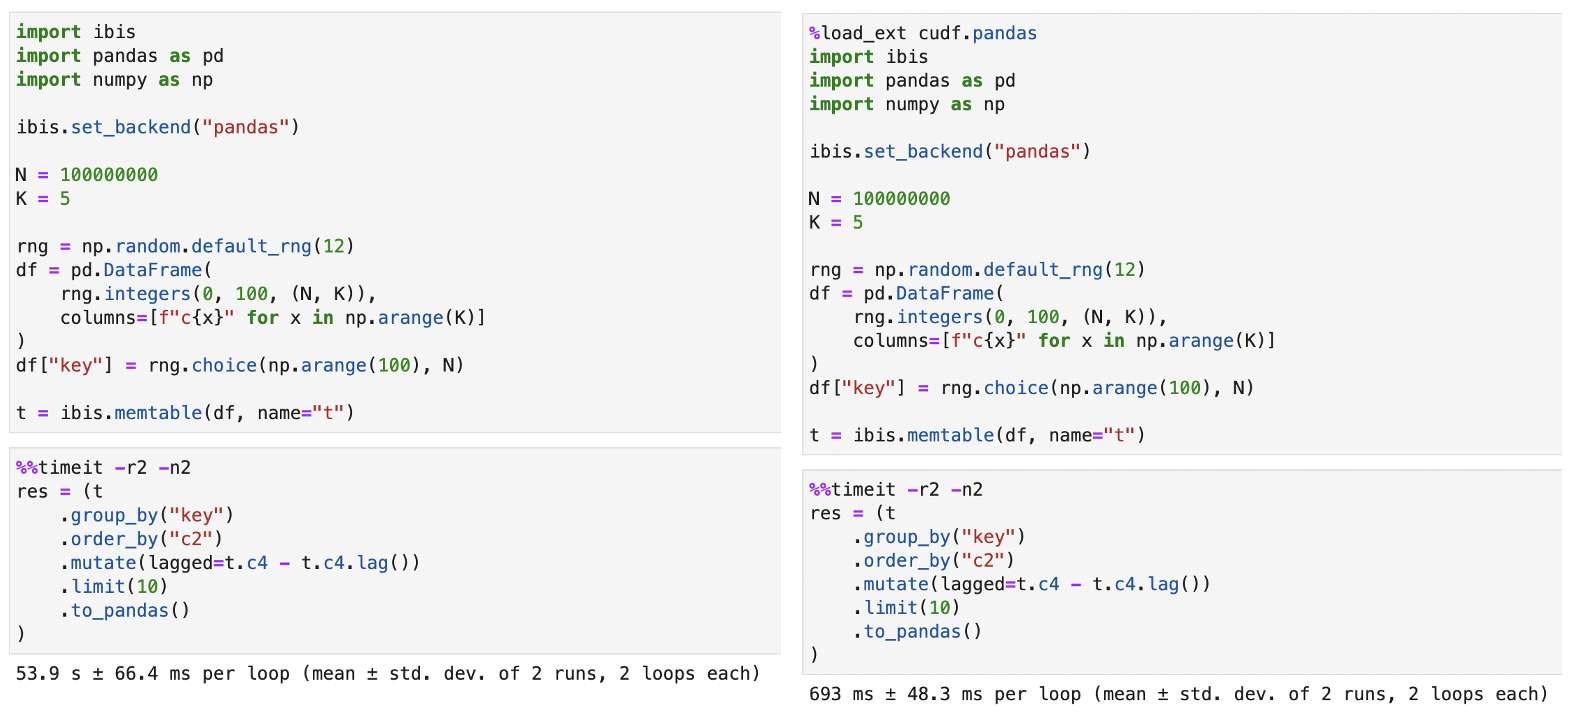

Using cudf.pandas, third-party libraries like Plotly benefit from GPU acceleration for pandas operations. For example, loading cudf.pandas allows Ibis to leverage GPU acceleration seamlessly, with no code changes needed.

#**The Ultimate Pandas Power-Up!**


Imagine this: you're cruising along with pandas, your go-to DataFrame library, but then things start to slow down. No worries! Just load cudf.pandas, and bam—your existing code gets a turbo boost from GPU acceleration!

Curious to dive deeper? Head over to:

[link text](https://rapids.ai/cudf-pandas/)


and get ready to supercharge your data processing!

https://rapids.ai/cudf-pandas/